In [1]:
# 必要なライブラリを読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
#前処理したデータを読み込み
#train = pd.read_csv('edited_train.csv').drop(["SOR"],axis = 1)
train = pd.read_csv('edited_train.csv').drop(["y", "year", 'hokkaido','kansai', 'disconfort', 'kantou', 'temperature', 'humidity',  'kyusyu','shikoku', 'tohoku', 'tyubu', 'tyugoku','stadium',"home area","away area"],axis = 1)
test = pd.read_csv('edited_test.csv').drop([ "year", 'hokkaido','kansai', 'disconfort', 'kantou', 'temperature', 'humidity',  'kyusyu','shikoku', 'tohoku', 'tyubu', 'tyugoku','stadium',"home area","away area"],axis = 1)
#data1.head(10)
top6_index=train.corr()['logy'].abs().nlargest(15).index 
top6_index[1:]

Index(['stage', 'total_p_score', 'capa', 'distance(min)', 'home rank',
       'area rank', 'rerative distance', 'away rank', 'id', 'holiday',
       'weather rank', 'month', 'match day'],
      dtype='object')

In [9]:
# データの標準化
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#X = train.loc[:,top6_index[1:]].drop(["month", 'accessibility'],axis=1)
#testX = test.loc[:,top6_index[1:]].drop(["month", 'accessibility'],axis=1)
X = train.loc[:,top6_index[1:]].drop(["month","id"],axis=1)
testX = test.loc[:,top6_index[1:]].drop(["month","id"],axis=1)

#X = train.loc[:,['stage', 'total_p_score', 'capa', 'distance(min)','home rank', 'area rank', 'rerative distance', 'away rank','weather rank', 'match day']]
y = train.loc[:,["logy"]].values.reshape(-1)

scaler = StandardScaler()
X_std = scaler.fit_transform(X) # Xを標準化した行列を生成
testX_std = scaler.fit_transform(testX)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.25, random_state = 4903)

/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [10]:
ele = 8

In [11]:
X.columns

Index(['stage', 'total_p_score', 'capa', 'distance(min)', 'home rank',
       'area rank', 'rerative distance', 'away rank', 'holiday',
       'weather rank', 'match day'],
      dtype='object')

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8) # 主成分を6まで取得
X_pca = pca.fit_transform(X_train)

In [13]:
# 累積寄与率を出力
# np.cumsum()で固有値の累積をとる
# [第1主成分までの累積寄与率 第2主成分までの累積寄与率 ...]
print(np.cumsum(pca.explained_variance_ratio_))

[0.25719426 0.36420329 0.46607524 0.55710895 0.64575091 0.72838605
 0.80465814 0.87193839]


In [14]:
# 2次関数の変数変換
from sklearn.preprocessing import PolynomialFeatures
# 2次の多項式規定を生成
quad = PolynomialFeatures(degree=1)
# 生成した基底関数で変数変換を実行
X_quad = quad.fit_transform(X_pca[:, 0:ele])

In [15]:
# LASSO回帰を実行
# LASSO回帰のクラスを読み込み
from sklearn.linear_model import Lasso
# LASSO回帰のインスタンスを生成
model_lasso = Lasso(alpha=0)
# データを学習させる
model_lasso.fit(X_quad, y_train)

/Users/itarou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
from sklearn.metrics import mean_squared_error as mse
print('train RMSE:%.3f'%(mse(np.exp(y_train), np.exp(model_lasso.predict(X_quad))) ** (1/2)))
Xd = pca.transform(X_test)
X_quad_test = quad.fit_transform(Xd[:, 0:ele])
print('test RMSE:%.3f'%(mse(np.exp(y_test), np.exp(model_lasso.predict(X_quad_test))) ** (1/2)))

train RMSE:4751.238
test RMSE:4792.009


In [20]:
from sklearn.model_selection import GridSearchCV
params = {"alpha":np.logspace(-5, -2, 24)}
# (モデルのインスタンス, 試したいパラメータの値, 分割方法)
gs_rd = GridSearchCV(Lasso(), params,cv = 5)
gs_rd.fit(X_quad, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.00000e-05, 1.35031e-05, 1.82335e-05, 2.46209e-05, 3.32460e-05,
       4.48925e-05, 6.06190e-05, 8.18547e-05, 1.10530e-04, 1.49250e-04,
       2.01534e-04, 2.72134e-04, 3.67466e-04, 4.96195e-04, 6.70019e-04,
       9.04736e-04, 1.22168e-03, 1.64965e-03, 2.22754e-03, 3.00788e-03,
       4.06159e-03, 5.48442e-03, 7.40568e-03, 1.00000e-02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
gs_rd.best_score_

0.7062355565779332

In [22]:
gs_rd.best_params_

{'alpha': 1e-05}

/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


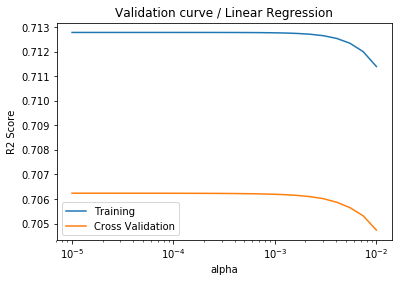

In [23]:
# 検証曲線
plt.semilogx(params["alpha"], gs_rd.cv_results_["mean_train_score"], label="Training")
plt.semilogx(params["alpha"], gs_rd.cv_results_["mean_test_score"], label="Cross Validation")
plt.xlabel("alpha")
plt.ylabel("R2 Score")
plt.title("Validation curve / Linear Regression")
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error as mse
print('train RMSE:%.3f'%(mse(np.exp(y_train), np.exp(gs_rd.predict(X_quad))) ** (1/2)))
Xd = pca.transform(X_test)
X_quad_test = quad.fit_transform(Xd[:, 0:ele])
print('test  RMSE:%.3f'%(mse(np.exp(y_test), np.exp(gs_rd.predict(X_quad_test))) ** (1/2)))

train RMSE:4751.203
test  RMSE:4791.972


train RMSE:4791.972


In [20]:
params

{'alpha': array([1.00000000e-02, 1.82334800e-02, 3.32459793e-02, 6.06189899e-02,
        1.10529514e-01, 2.01533769e-01, 3.67466194e-01, 6.70018750e-01,
        1.22167735e+00, 2.22754295e+00, 4.06158599e+00, 7.40568469e+00,
        1.35031404e+01, 2.46209240e+01, 4.48925126e+01, 8.18546731e+01,
        1.49249555e+02, 2.72133877e+02, 4.96194760e+02, 9.04735724e+02,
        1.64964807e+03, 3.00788252e+03, 5.48441658e+03, 1.00000000e+04])}

In [23]:
gs_rd.fit(X_quad, y_train)

/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.00000e-02, 1.82335e-02, 3.32460e-02, 6.06190e-02, 1.10530e-01,
       2.01534e-01, 3.67466e-01, 6.70019e-01, 1.22168e+00, 2.22754e+00,
       4.06159e+00, 7.40568e+00, 1.35031e+01, 2.46209e+01, 4.48925e+01,
       8.18547e+01, 1.49250e+02, 2.72134e+02, 4.96195e+02, 9.04736e+02,
       1.64965e+03, 3.00788e+03, 5.48442e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
gs_rd.best_score_

0.47296126153188517

In [25]:
gs_rd.best_params_

{'alpha': 272.13387683753086}

In [171]:
from sklearn.metrics import mean_squared_error as mse
print('train RMSE:%.3f'%(mse(y_train, gs_rd.predict(X_train)) ** (1/2)))

ValueError: shapes (1464,10) and (9,) not aligned: 10 (dim 1) != 9 (dim 0)

In [55]:
def gen_cv():
    m_train = np.floor(len(y)*0.75).astype(int)#このキャストをintにしないと後にハマる
    train_indices = np.arange(m_train)
    test_indices = np.arange(m_train, len(y))
    yield (train_indices, test_indices)


In [57]:
print("訓練データ、交差検証データ、テストデータの数 = ", end="")
print(len(next(gen_cv())[0]), len(next(gen_cv())[1]), len(y) )

訓練データ、交差検証データ、テストデータの数 = 1464 489 1953


In [11]:
params = {"alpha":np.logspace(-2, 4, 24)}

In [31]:

gridsearch = GridSearchCV(Ridge(), params, cv=7, scoring="r2", return_train_score=True)
gridsearch.fit(X_quad, y_train)
print("αのチューニング")
print("最適なパラメーター =", gridsearch.best_params_, "精度 =", gridsearch.best_score_)
print()

αのチューニング
最適なパラメーター = {'alpha': 13.503140378698722} 精度 = 0.7607017785215663



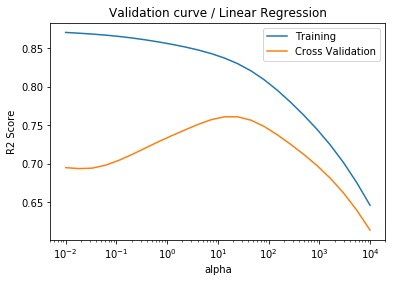

In [32]:
# 検証曲線
plt.semilogx(params["alpha"], gridsearch.cv_results_["mean_train_score"], label="Training")
plt.semilogx(params["alpha"], gridsearch.cv_results_["mean_test_score"], label="Cross Validation")
plt.xlabel("alpha")
plt.ylabel("R2 Score")
plt.title("Validation curve / Linear Regression")
plt.legend()
plt.show()

In [33]:
regr = Ridge(alpha=gridsearch.best_params_["alpha"])
regr.fit(X_quad, y_train)
print("切片と係数")
print(regr.intercept_)
print(regr.coef_)
print()
# テストデータの精度を計算
print("テストデータにフィット")
print("テストデータの精度 =", regr.score(X_quad_test, y_test))
print()
print("※参考")
print("訓練データの精度 =", regr.score(X_quad, y_train))
print("交差検証データの精度 =", regr.score(X_quad, y_train))

切片と係数
[8810.84140616]
[[    0.           975.61868723  -534.7486827    987.95672968
    294.90026468   297.32550096  -708.97838838   641.92731459
   -586.49554258  -134.62230746   173.62828839    -6.18616763
   -802.50932155   907.26173853   -59.77720109  1068.42875021
  -1502.59183198  1315.54665594  -644.45575826  1307.56542915
   -746.40446004   281.1731306  -1227.9698494   -471.83483954
   -958.30900884   820.45395341  -998.52946603  1249.03964009
   -166.03369765  -689.2080127   1503.78403948  1479.03975725
   2441.11462778 -1857.13379662  2782.17856386 -1873.32062419
    614.27047206   505.72480647   -34.80194174    61.36488932
    -17.93092706  -853.70846818   130.73357893   -85.02515077
    436.12199372  -519.40122136   -87.41695208  -322.71064466
    286.40080642  -881.2808357    -80.35375199    90.53676076
     58.03867125   219.69848312   836.4958981    148.53654443
   -449.9181621   -327.46147232  -820.25905161   -23.06219549
    201.96038279   230.57608662  -239.16262257  

In [35]:
X_pca_test = pca.transform(X_test)

In [41]:
from sklearn.svm import SVR

# ハイパーパラメータのチューニング
params_cnt = 20
#params = {"C":np.logspace(10,100,params_cnt), "epsilon":np.logspace(-1,1,params_cnt)}
params={'C': [20000,30000],'gamma': [0.001,0.0001]}
gridsearch = GridSearchCV(SVR(kernel="linear"), params, cv=5, scoring="r2", return_train_score=True)
gridsearch.fit(X_pca[:, 0:ele], y_train)
print("C, εのチューニング")
print("最適なパラメーター =", gridsearch.best_params_)
print("精度 =", gridsearch.best_score_)
print()

/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

C, εのチューニング
最適なパラメーター = {'C': 20000, 'gamma': 0.001}
精度 = 0.6326225000793771



In [40]:
regr = SVR(kernel="linear", C=gridsearch.best_params_["C"], epsilon=gridsearch.best_params_["gamma"])
regr.fit(X_train, y_train)
print("切片と係数")
print(regr.intercept_)
print(regr.coef_)
print()
# テストデータの精度を計算
print("テストデータにフィット")
print("テストデータの精度 =", regr.score(X_test, y_test))
print()
print("※参考")
print("訓練データの精度 =", regr.score(X_train, y_train))
#print("交差検証データの精度 =", regr.score(X_norm[valid_indices, :], y[valid_indices]))


/Users/itarou/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


切片と係数
[10095.29300296]
[[1964.94885791 3218.08729977  -83.77765422  203.74846863  203.10907717
  -645.38307754 -319.8355835    33.3100299   486.47719769 -149.95126894
   407.17652111 1442.49871392 -573.64824794  425.13977981  689.92870311
  -144.09130722]]

テストデータにフィット
テストデータの精度 = 0.65685525050342

※参考
訓練データの精度 = 0.6874469497834126


In [97]:
from sklearn.metrics import mean_squared_error as mse
print('train RMSE:%.3f'%(mse(y_train, regr.predict(X_train)) ** (1/2)))

train RMSE:4926.117
